In [1]:
from segment.modules.semibase import Base
from segment.modules.semseg.deeplabv3plus import DeepLabV3Plus
import torch
from torchvision import transforms as T
from torchvision.transforms import functional as F
import torch.nn as nn
from PIL import Image
import numpy as np
from segment.util import  color_map
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import cleanlab

D:\Dev_soft\Anaconda3\envs\MyPYL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Dev_soft\Anaconda3\envs\MyPYL\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
D:\Dev_soft\Anaconda3\envs\MyPYL\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


In [2]:
num_classes = 3
ckpt_path = '../temp/val_OD_dice=0.847466.ckpt'

cmap = color_map('eye')

model = DeepLabV3Plus('resnet50',num_classes)

sd = torch.load(ckpt_path, map_location='cpu')['state_dict']
if 'state_dict' in sd:
    # If 'state_dict' exists, use it directly
    sd = sd['state_dict']
new_state_dict = {}
for key, value in sd.items():
    # if not key.startswith('module.'):  # 如果关键字没有"module."前缀，加上该前缀
    #     if 'module.' + key in model.state_dict():
    #         # 模型在多GPU上训练并保存，加载权重时加上"module."前缀
    #         key = 'module.' + key
    key = key.replace('model.', '')
    new_state_dict[key] = value
model.load_state_dict(new_state_dict)
model.eval()


image_path = './T0001.jpg'
mask_path = './T0001.bmp'
image_tensor = T.ToTensor()(Image.open(image_path)).unsqueeze(dim=0)
mask_tensor = torch.tensor(np.array((Image.open(mask_path)))).squeeze()


output = model(image_tensor)
backbone_feat,out_fuse,out_classifier, logits = output['backbone_features'],output['out_fuse'],output['out_classifier'], output['out']

In [11]:
mask_tensor = mask_tensor.unsqueeze(dim=0)
mask_tensor = mask_tensor.to(torch.long)
with torch.no_grad():
    prob = torch.softmax(logits, dim=1)
    entropy = -torch.sum(prob * torch.log(prob + 1e-10), dim=1)

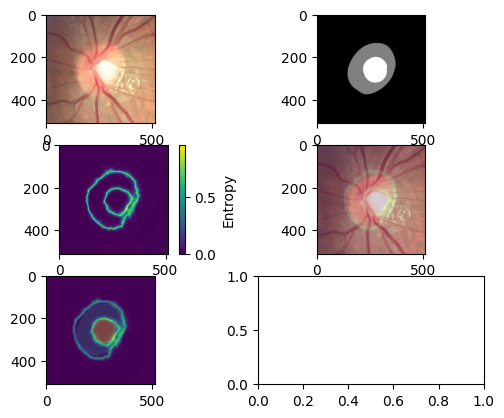

In [41]:
image_arr = image_tensor.squeeze().permute(1,2,0).numpy()
mask_arr = mask_tensor.squeeze().numpy()
entropy_map = entropy.squeeze().numpy()
fig,ax = plt.subplots(3,2)
ax[0,0].imshow(image_arr)
ax[0,1].imshow(mask_arr,cmap='gray')
heatmap = ax[1,0].imshow(entropy_map,cmap='viridis', vmin=0, vmax=0.96, interpolation='nearest')
cbar = fig.colorbar(heatmap,ax=ax[1,0])
cbar.set_label('Entropy')

ax[1,1].imshow(entropy_map[:,:,None])
ax[1,1].imshow(image_arr,alpha=0.8)

ax[2,0].imshow(entropy_map)
ax[2,0].imshow(mask_arr*100,alpha=0.3)

plt.show()

In [24]:
print(np.max(entropy_map))
print(np.min(entropy_map))

0.95400345
0.00035336986
